## Notebook 3. Case study (Alpine foreland)

In this notebook we present a method to calculate the exhumation of a Noddy model. For this, you need to make sure you have added the samples to your Noddy model. This can be done by adding elliptical plugs in Noddy (keep the dimensions as small as possible - I use 200x200x200). The plugs should be added before the faulting or folding events. In "full" event view, add the plugs until they are visible at surface after the structural events. 

In [13]:
import pynoddy
import importlib
importlib.reload(pynoddy)
import pynoddy.history
import pynoddy.output
import pandas as pd
import numpy as np
import sys,os
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../functions'))
from exh_functions import *
from exh_processing import *
from exh_plotting import *

In [6]:
#Note: for computing the noddy models, make sure that you have the noddy executable downloaded - you can find this on pynoddy's
#github page, all you need to do is clone the repository and set the path. Does not work on Mac.
noddy_path = r'C:\Users\Sofia\pynoddy\noddyapp\noddy_win64.exe'

In [3]:
folder = "CaseStudy"
output_folder = f"outputs/{folder}"
os.makedirs(output_folder, exist_ok=True)

Load the samples:

In [5]:
samples = pd.read_csv(f'../data/bregenz_data.csv', delimiter = ',')
samples

,X,Y,Z,sample,group
0,1626.7528,4990.4679,710,60,a
1,8145.5806,1315.1883,519,55,c
2,13815.5822,12609.0000,541,50,d
3,15737.3562,14061.0000,521,45,d
4,18309.8314,15806.0000,636,40,d
5,19436.3479,16453.0000,740,35,d
6,21076.8867,17473.0000,765,30,a
7,23018.3551,18905.0000,894,25,c
8,23685.2056,19362.0000,920,15,d
9,25491.5708,792.0000,920,10,b


Load the model with the samples:

In [7]:
model = 'bregenz'

In [8]:
history = '../models/Bregenz_Samples.his'
output_name = f'{output_folder}/{model}_noddy_out'
pynoddy.compute_model(history, output_name, 
                      noddy_path = noddy_path)

hist = pynoddy.history.NoddyHistory(history)
out = pynoddy.output.NoddyOutput(output_name)

#make it hd 
hist.change_cube_size(100)
hist_hd = f'{output_folder}/{model}_hist_hd.his'
out_hd = f'{output_folder}/{model}_noddy_out_hd'
hist.write_history(hist_hd)
pynoddy.compute_model(hist_hd, out_hd, noddy_path = noddy_path)
out_hd = pynoddy.output.NoddyOutput(out_hd)

outputs/CaseStudy/bregenz_noddy_out
outputs/CaseStudy/bregenz_noddy_out_hd


### Sensitivity analysis
First, let's check out which parameters to choose to vary in the MCMC. We use a local sensitivity analysis or scenario analysis to vary one parameter at a time, while keeping all other parameters constant. We check the sensitivity of the exhumation output to the parameter variations. This code can be parallelized and must be run in the cluster, otherwise it's too slow. We choose event number 22 to carry out the sensitivity analysis. For the complete code, check: '../cluster/code/sensitivity.py'

In [43]:
parameters = ['Amplitude', 'Slip', 'X', 'Y', 'Z']
parameters_angle = ['Dip','Dip Direction', 'Pitch']

In [44]:
#fault 22 is related to sample #4 with a lith id #15
sample_num = [4]
lith = [15]

In [45]:
og_depths = [] #calculate the original depth before exhumation for each sample (they are plugs in noddy)
for event_name, evento in hist.events.items():
    if isinstance(evento, pynoddy.events.Plug):
        z = evento.properties['Z']  
        og_depths.append(z)
og_depths = og_depths[4] #select only the values for the sample we are currently using

In [79]:
og_exh = pd.read_csv('../data/bregenz_exh.csv') #starting exhumation for each sample in the model
diff = np.load('../data/diff.npy')
diff = diff[4] #difference between the topography and the maximum noddy extent
og_exh = og_exh['exhumation'][4]

In [12]:
#This is the code we use on the cluster.
for param in parameters_angle:
    change_unit = 0
    hist_copy = copy.deepcopy(hist)
    
    #starting_param = hist_copy.events[22].properties[param] - (26 * 200) #this is for non-angle params
    starting_param = 0 #for angle params
    print(f"starting param: {starting_param}")
    
    e = []
    p = []
    exhumation = pd.DataFrame(columns = ['Parameters', 'Exhumation'])
    for i in range(90):
        print(f"This is run number {i}")
        new_param = starting_param + change_unit
        print(f"new_param {new_param}")
        hist_copy.events[22].properties[param] = new_param
        
        #calculate the exhumation
        exh,_,_ = calc_new_position(hist_copy,diff, og_depths, lith, samples)
        print(exh['exhumation'])
        p.append(new_param)
        e.append(exh['exhumation'])
        
        #we change the parameter values by 2 degrees each time
        change_unit += 2
        
    exhumation['Parameters'] = p
    exhumation['Exhumation'] = e
    exhumation.to_csv(f"{output_folder}/{model}_sensitivity_analysis/exhumation_{param}.csv", index = False)

starting param: 0
This is run number 0
new_param 0
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 1
new_param 2
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 2
new_param 4
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 3
new_param 6
synthetic_outputs/temp_out
4    2653.363946
Name: exhumation, dtype: float64
This is run number 4
new_param 8
synthetic_outputs/temp_out
4    2653.363946
Name: exhumation, dtype: float64
This is run number 5
new_param 10
synthetic_outputs/temp_out
4    2653.363946
Name: exhumation, dtype: float64
This is run number 6
new_param 12
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 7
new_param 14
synthetic_outputs/temp_out
4    2653.363946
Name: exhumation, dtype: float64
This is run number 8
new_param 16
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dty

4    2640.376944
Name: exhumation, dtype: float64
This is run number 74
new_param 148
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 75
new_param 150
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 76
new_param 152
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 77
new_param 154
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 78
new_param 156
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 79
new_param 158
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 80
new_param 160
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 81
new_param 162
synthetic_outputs/temp_out
4    2640.376944
Name: exhumation, dtype: float64
This is run number 82
new_param 164
synthetic_

#### Check sensitivity study results

In [71]:
def clean_df(df):
    df['Exhumation'] = df['Exhumation'].str.extract(r'(\d+\.\d+)').astype(float)
    return df

def calc_sensitivity(exhumation, og_exh):
    sensitivity = ((exhumation - og_exh)/(og_exh)) * 100
    return sensitivity

In [75]:
import os
sensitivity_files = os.listdir(f'{output_folder}/{model}_sensitivity_analysis')

sens_all = []
for file in sensitivity_files:
    print(f"file:{file}")
    sens_param = []
    file_path = os.path.join(f'{output_folder}/{model}_sensitivity_analysis', file)
    exhumation_param = pd.read_csv(file_path)
        
    exhumation_param_clean = clean_df(exhumation_param)
    
    for i in range(len(exhumation_param_clean)):
        sens_param.append(calc_sensitivity(exhumation_param_clean['Exhumation'][i], og_exh))
        
    sens_all.append(sens_param)

file:exhumation_Amplitude.csv
file:exhumation_Dip Direction.csv
file:exhumation_Pitch.csv
file:exhumation_Slip.csv
file:exhumation_X.csv
file:exhumation_Y.csv
file:exhumation_Z.csv


## MCMC SIMULATION results

Just a note:
- Sample B55 = sample 1 = event 20 = plug lith 12 = backthrust
- Sample B50 = sample 2 = event 21 = plug lith 13 = Horn thrust
- Sample B40 = sample 4 = event 22 = plug lith 15 = Salmas thrust
- Sample B30 = sample 6 = event 24 = plug lith 17 = Steineberg syncline thrust

This should also be run in the cluster. While it cannot be parallelized, it is still safer to run in the cluster because it is very likely to crash on a laptop, as the run time is around 5 days. Here we will only study the results, of 1000 accepted models after a total of 3088 runs. For the full MCMC code, check: '../cluster/case_mcmc_new.py'.

In [103]:
#some modeling parameters we used:
prop_list = ['Z','Slip']
event = [21,22,24]
std = [300,800]

#extract the original parameters
og_params = []
for i in event:
    event_data = [i]
    for j, props in enumerate(prop_list):
        propert = hist.events[i].properties[props]
        event_data.append(propert)
    og_params.append(event_data)
   
og_params_df = pd.DataFrame(og_params, columns = ['event', 'Z', 'Slip'])

In [89]:
acc_params = pd.read_csv(f'{output_folder}/{model}_acc_params.csv')
rej_params = pd.read_csv(f'{output_folder}/{model}_rej_params.csv')

In [81]:
acc_fault21 = acc_params['event_name'] == 21.0
acc_fault22 = acc_params['event_name'] == 22.0
acc_fault24 = acc_params['event_name'] == 24.0
rej_fault21 = rej_params['event_name'] == 21.0
rej_fault22 = rej_params['event_name'] == 22.0
rej_fault24 = rej_params['event_name'] == 24.0

In [83]:
acc_params_fault21 = acc_params[acc_fault21]
acc_params_fault22 = acc_params[acc_fault22]
acc_params_fault24 = acc_params[acc_fault24]
rej_params_fault21 = rej_params[rej_fault21]
rej_params_fault22 = rej_params[rej_fault22]
rej_params_fault24 = rej_params[rej_fault24]

In [85]:
accepted_params = [acc_params_fault21, acc_params_fault22, acc_params_fault24]
## There are 1000 accepted params, but the indices go up to 3000

### Prior versus posterior parameter distributions

In [107]:
apf21 = acc_params_fault21.values
apf22 = acc_params_fault22.values
apf24 = acc_params_fault24.values
accepted_stuff = [apf21, apf22, apf24]

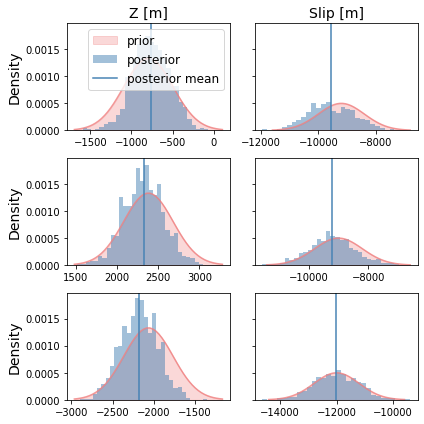

In [109]:
nrow=3
ncol=2
fig,ax = plt.subplots(nrow,ncol,figsize=(6,6), sharey = True)

for j,prop in enumerate(prop_list):
    for i in range(nrow):
        x = np.linspace(og_params_df[prop][i] - 3 * std[j], og_params_df[prop][i] + 3 * std[j])
        y = 1 / (std[j] * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - og_params_df[prop][i]) / std[j]) ** 2)
        ax[i,j].plot(x,y, color = 'lightcoral', alpha = 0.8)
        ax[i,j].fill_between(x,y,alpha = 0.3, color = 'lightcoral', label = 'prior')
        ax[i,j].hist(accepted_stuff[i][...,j+1], bins = 30, density = True, histtype = 'stepfilled', 
                     color = 'steelblue', alpha = 0.5, label = 'posterior')
        ax[i,j].axvline(x = accepted_stuff[i][...,j+1].mean(), color = 'steelblue', label = 'posterior mean')

#labels and stuff
ax[0,0].set_ylabel('Density', fontsize = 14)
ax[1,0].set_ylabel('Density', fontsize = 14)        
ax[2,0].set_ylabel('Density', fontsize = 14)
ax[0,0].set_title('Z [m]', fontsize = 14)
ax[0,1].set_title('Slip [m]', fontsize = 14)
ax[0,0].legend(fontsize = 12)

plt.tight_layout()

plt.savefig(f'../figures/{model}_priorvspost.svg')

### Convergence

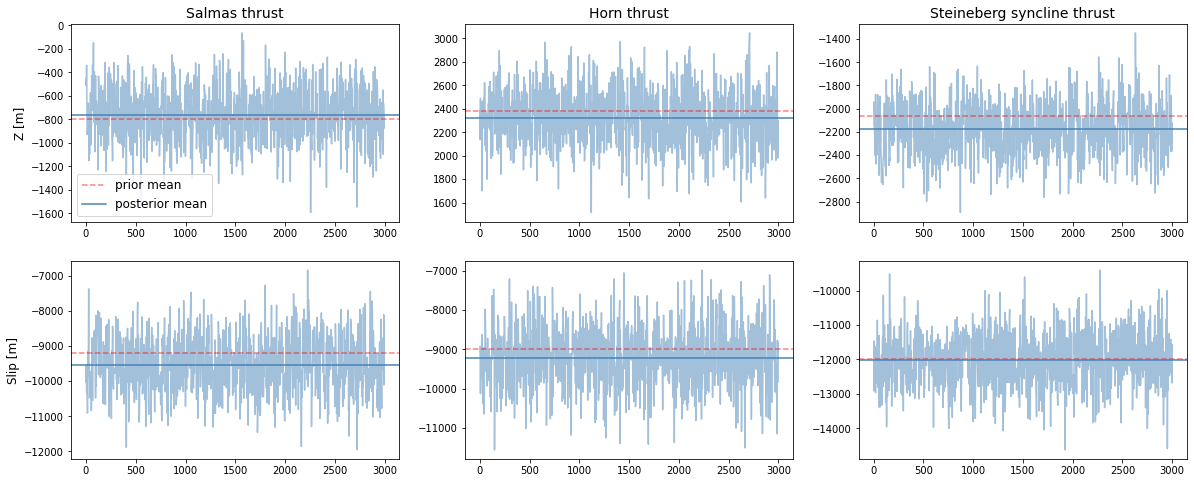

In [101]:
nrow=2
ncol=3
fig,ax = plt.subplots(nrow,ncol,figsize=(20,8))

for j,prop in enumerate(prop_list):
    for i in range(ncol):
        ax[j,i].plot(accepted_params[i][prop], alpha = 0.5, color = 'steelblue')
        ax[j,i].axhline(y = og_params_df[prop][i], color = 'red', linestyle = '--', alpha = 0.5, label = 'prior mean')
        ax[j,i].axhline(y = accepted_params[i][prop].mean(), color = 'steelblue', label = 'posterior mean')

ax[0,0].set_title('Salmas thrust', fontsize = 14)
ax[0,1].set_title('Horn thrust', fontsize = 14)
ax[0,2].set_title('Steineberg syncline thrust', fontsize = 14)
ax[0,0].set_ylabel('Z [m]', fontsize = 12)
ax[1,0].set_ylabel('Slip [m]', fontsize = 12)
ax[0,0].legend(fontsize = 12)

In [112]:
# geweke test for convergence
def geweke(samples, segment_length, parameter, burnin):
    
    burn_in = int(len(samples) * burnin) #burn-in considered as the first 2 percent of the accepted samples.
    samples = samples[burn_in:] #remove the first 2 percent of the samples.
    
    num_segments = len(samples) // segment_length
    
    params = samples[parameter]
    
    #if parameter in [1]:
    #    params = samples[:,0,1]
    #elif parameter in [2]:
    #    params = samples[:,0,2]
    #elif parameter in [3]:
    #    params = samples[:,1,1]
    #else:
    #    params = samples[:,1,2]
    
    z_scores = []
    for i in range(num_segments):
        start_index = i * segment_length
        end_index = (i + 1) * segment_length
        
        mean_first = np.mean(params[:segment_length])
        mean_last = np.mean(params[start_index:end_index])
        
        var_first = np.var(params[:segment_length])
        var_last = np.var(params[start_index:end_index])
        
        z_score = (mean_first - mean_last) / np.sqrt(var_first / segment_length + var_last / segment_length)
        z_scores.append(z_score)
    return z_scores

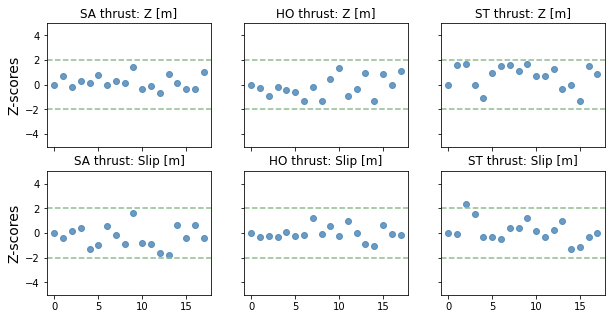

In [113]:
from itertools import cycle
seg_length = 50
n_draws = 5000
burnin = 0.1
nrow = 2
ncol = 3
n_draws = 1000

fig, ax = plt.subplots(nrow,ncol, figsize = (10,5), sharey = True, sharex = True)
param_labels = cycle(['SA thrust: Z [m]', 'HO thrust: Z [m]', 'ST thrust: Z [m]', 
                      'SA thrust: Slip [m]', 'HO thrust: Slip [m]', 'ST thrust: Slip [m]'])

for i, prop in enumerate(prop_list):
    for j in range(ncol):
        z_score = geweke(accepted_params[j], seg_length, prop, burnin)
        segments = np.arange((n_draws - (n_draws*burnin))/seg_length)
        ax[i,j].scatter(segments, z_score, color = 'steelblue', alpha = 0.8)
        ax[i,j].set_ylim(-5,5)
        ax[i,j].axhline(y = 2, color = 'darkseagreen', linestyle = '--')
        ax[i,j].axhline(y = -2, color = 'darkseagreen', linestyle = '--')
        ax[i,j].set_title(next(param_labels))
ax[0,0].set_ylabel('Z-scores', fontsize = 14)
ax[1,0].set_ylabel('Z-scores', fontsize = 14)
plt.savefig(f'../figures/{model}_geweke.png')

Text(0, 0.5, 'Autocorrelation')

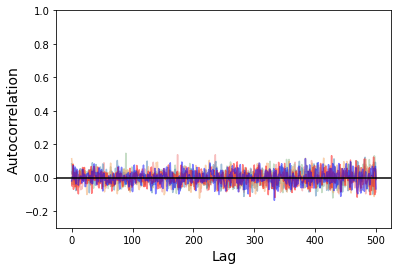

In [114]:
param_labels = cycle(['SA Z', 'HO Z', 'ST Z', 'SA Slip', 'HO Slip', 'ST Slip'])
colors = cycle(['lightcoral','darkseagreen', 'steelblue', 'sandybrown', 'red', 'blue'])
max_lag = 500

burn_in = int(len(accepted_stuff[0]) * burnin)
accepted_burn = []
for i in range(len(accepted_stuff)):
    params = accepted_stuff[i][burn_in:]
    accepted_burn.append(params)

nrow=2
ncol=3

for j,prop in enumerate(prop_list):
    for i in range(ncol):
        autocorr_values = []
        for lag in range(max_lag+1):
            autocorr = np.corrcoef(accepted_burn[i][...,j+1][:-(lag+1)], accepted_burn[i][...,j+1][(lag+1):])[0,1]
            autocorr_values.append(autocorr)

        plt.plot(range(max_lag+1), autocorr_values, label = next(param_labels), color = next(colors), alpha = 0.5)
        plt.ylim(-0.3, 1.0)

plt.axhline(y = 0, color = 'black')
plt.xlabel('Lag', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 14)
        